## Avaliação do Algoritmo K-Nearest Neighbor em Datasets com Noise e Outliers

Começamos por implementar o **algoritmo K-Nearest Neighbor (KNN)**, baseando-nos nas implementações: https://github.com/AssemblyAI-Community/Machine-Learning-From-Scratch, https://github.com/AssemblyAI-Community/Machine-Learning-From-Scratch/tree/main/01%20KNN.

O algoritmo KNN funciona segundo o princípio de que um novo exemplo será classificado de acordo com as classes mais frequentes entre os seus k vizinhos mais próximos no espaço das características.

Para medir a distância entre os pontos, escolhemos a **distância Euclidiana**.

In [1]:
import numpy as np
import pandas as pd
from collections import Counter

# Função euclidiana
def euclidean_fun(x1,x2):
    distance = np.sqrt(np.sum((x1-x2)**2))
    return distance


class KNN:
    # Definir o k
    def __init__(self, k):
        self.k = None if k == 0 else k
    
    # Função de treino (armazena os dados)
    def fit(self, X,y):
        self.X_train = X   # matriz de caracteristicas
        self.y_train = y   # vetor com as classes correspondentes

    # Prevê
    def predict(self,X):
        predictions = [self._predict(x) for x in X]
        return predictions
    
    def _predict(self, x):
        # Calcula as distâncias de cada exemplo ao ponto x
        distances = [euclidean_fun(x, x_train) for x_train in self.X_train]

        # Vai buscar os k valores mais próximos
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]

        # Vê qual é a classe mais comum entre os k escolhidos
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]


Decidimos criar funções que introduzissem noise e outliers às bases de dados para que fosse mais fácil fazer uma avaliação empírica da robustez do algoritmo em cenários com dados corrompidos.

Começamos por definir uma função que **introduz noise** ás classes da base de dados fornecida. Para isso alteramos um determinado número de classes corretas para classes incorretas, com base num parâmetro nivel_noise, que representa a fração de elementos afetados.

Esta função introduz classes erradas de forma controlada, permitindo-nos observar como o algoritmo KNN reage a diferentes níveis de noise nos dados de treino.

In [2]:
def noise(y, nivel_noise):
    y_noisy = y.copy()
    n = int(nivel_noise * len(y)) # calculo de quantos elementos do vetor vão ser alterados conforme o nível de noise que se introduz
    indices = np.random.choice(len(y), n, replace=False) # escolhe aleatoriamente n linhas diferentes para alterar (replace = False impede repetições) 
    for i in indices:   # para cada indice
        current = y_noisy[i]    # guarda a classe atual
        other_classes = list(set(y_noisy) - {current})  # cria uma lista de todas as classes diferentes da atual
        if other_classes:   # se a lista não for nula
            y_noisy[i] = np.random.choice(other_classes)   # altera para uma outra classe
    return y_noisy

Também criámos uma função que **gera outliers no conjunto de treino** com o objetivo de introduzir exemplos artificiais que apresentam valores anormais nas suas características (X).

Este procedimento adiciona exemplos com valores nas extremidades ou fora da distribuição natural dos dados originais.
A variável *nivel_outliers* controla a proporção de outliers a introduzir, enquanto a magnitude define o quão afastados os valores gerados estarão do comportamento normal do dataset.

In [3]:
def outliers(X, y, nivel_outliers, magnitude=10.0): # magnitude = até quanto queremos "sair" dos limites normais para gerar outliers
    n_outliers = int(len(X) * nivel_outliers)   # calcula quantos outliers vão ser criados
    n_features = X.shape[1] # conta o n de atributos que cada exemplo tem
    
    # define um intervalo de valores extremo para gerar os outliers
    # usa o 5º percentil como limite inferior
    low = np.percentile(X, 5) - magnitude
    # usa o 95º percentil como limite superior
    high = np.percentile(X, 95) + magnitude

    # gera n_outliers exemplos aleatorios com valores entre o low e o high
    outlier_X = np.random.uniform(
        low=low,
        high=high,
        size=(n_outliers, n_features)   # cada outlier tem n_features atribuidos
    )

    unique_labels = np.unique(y)    # encontra todos os valores diferentes que existem em y (classes)
    outlier_y = np.random.choice(unique_labels, size=n_outliers)    # escolhe aleatoriamente uma classe para cada um dos novos outliers
    
    # junta os novos outliers ao dataset original
    new_X = np.vstack((X, outlier_X))
    new_y = np.hstack((y, outlier_y))
    
    return new_X, new_y

### Avaliação das Previsões: Métricas de Desempenho e Matriz de Confusão

Para quantificar o desempenho do algoritmo KNN em diferentes cenários (dataset original, com ruído e com outliers), implementámos funções de avaliação que **calculam métricas de classificação binária** e apresentam visualmente os resultados através de uma **matriz de confusão**.

Definimos uma função que calcula as principais métricas : **Accuracy**, **Precision**, **Recall** e **F1-Score**.
Estas métricas são baseadas na contagem dos verdadeiros positivos (TP), falsos positivos (FP), falsos negativos (FN) e verdadeiros negativos (TN).

A função percorre todos os pares de valores reais e previstos, atualizando os contadores correspondentes e depois calcula cada métrica conforme a sua função matemática.

In [4]:
def metricas(y_true, y_predicted):
    unique_labels = np.unique(np.concatenate((y_true, y_predicted)))    # junta as classes true e predicted e encontra todas 

    classe_negativa, classe_positiva = sorted(unique_labels)  # organiza por ordem crescente qual é a classe negativa e a positiva

    TP = FP = FN = TN = 0   # inicializa os contadores
    for true, predicted in zip(y_true, y_predicted):
        if true == classe_positiva and predicted == classe_positiva:
            TP += 1
        elif true == classe_negativa and predicted == classe_positiva:
            FP += 1
        elif true == classe_positiva and predicted == classe_negativa:
            FN += 1
        elif true == classe_negativa and predicted == classe_negativa:
            TN += 1

    accuracy  = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall    = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score  = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return accuracy, precision, recall, f1_score

Implementámos também uma função que apresenta uma **matriz de confusão** em formato de gráfico usando *matplotlib*.
Esta matriz permite visualizar a distribuição de acertos e erros de forma intuitiva, distinguindo entre verdadeiros positivos, falsos positivos, falsos negativos e verdadeiros negativos.

In [5]:
import matplotlib.pyplot as plt

def matriz_confusao(y_true, y_pred, ax, title):
    unique_labels = np.unique(np.concatenate((y_true, y_pred)))

    classe_negativa, classe_positiva = sorted(unique_labels)

    TP = FP = FN = TN = 0
    for true, pred in zip(y_true, y_pred):
        if true == classe_positiva and pred == classe_positiva:
            TP += 1
        elif true == classe_negativa and pred == classe_positiva:
            FP += 1
        elif true == classe_positiva and pred == classe_negativa:
            FN += 1
        elif true == classe_negativa and pred == classe_negativa:
            TN += 1

    table_data = [
        ["", f"True {classe_positiva}", f"True {classe_negativa}"],
        [f"Predicted {classe_positiva}", f"TP = {TP}", f"FP = {FP}"],
        [f"Predicted {classe_negativa}", f"FN = {FN}", f"TN = {TN}"]
    ]

    table = ax.table(cellText=table_data, loc='center', cellLoc='center', colWidths=[0.3]*3)
    table.auto_set_font_size(False)
    table.set_fontsize(10)     
    table.scale(1.2, 1.2)        

    table[(1, 1)].set_facecolor('#b3e6b3')
    table[(1, 2)].set_facecolor('#f7c6c7')
    table[(2, 1)].set_facecolor('#f7c6c7')
    table[(2, 2)].set_facecolor('#b3e6b3')

    ax.axis('off')
    ax.set_title(title, fontsize=14, pad=8)

Para facilitar a comparação visual dos resultados obtidos nos diferentes cenários (dataset original, com noise e com outliers), implementámos uma função que **cria um gráfico de barras para as principais métricas de avaliação**: Accuracy, Precision, Recall e F1-Score.

In [6]:
def grafico_metricas(metricas, metricas_noise, metricas_outliers, nomes_metricas=None):
    if nomes_metricas is None:
        nomes_metricas = ["Accuracy", "Precision", "Recall", "F1-Score"]

    x = np.arange(len(nomes_metricas)) 
    width = 0.25  # Largura de cada barra

    fig, ax = plt.subplots(figsize=(10, 6))

    rects1 = ax.bar(x - width, metricas, width, label='Dataset Original')
    rects2 = ax.bar(x, metricas_noise, width, label='Dataset com Noise')
    rects3 = ax.bar(x + width, metricas_outliers, width, label='Dataset com Outliers')

    ax.set_ylabel('Valor das Métricas')
    ax.set_title('Gráfico de Comparação das Métricas de Avaliação para os Datasets')
    ax.set_xticks(x)
    ax.set_xticklabels(nomes_metricas)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.4f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    plt.tight_layout()
    plt.show()

Para garantir que o algoritmo KNN pudesse operar corretamente sem erros, foi necessário implementar uma função para *tratar valores em falta (NaN) nos datasets* utilizados.
Este processo assegura que todos os exemplos estejam completos e prontos para o treino e teste do modelo.
Esta função primeiro *elimina todas as colunas compostas exclusivamente por valores NaN*, uma vez que estas não fornecem informação útil ao modelo, senão para as células isoladas que ainda contenham NaN, *substitui o valor ausente pela média da respetiva coluna*.

Com esta abordagem, garantimos que o dataset fica livre de valores vazios, minimizando a perda de informação e evitando erros durante o treino do classificador.

In [7]:
def celulas_vazias(X):
    # remover colunas todas a NaN
    X = X[:, ~np.isnan(X).all(axis=0)]

    # se ainda existirem celulas vazias:
    if np.isnan(X).any():
        col_means = np.nanmean(X, axis=0)   # faz a média
        inds = np.where(np.isnan(X))    # encontra os indices onde existem NaN
        X[inds] = np.take(col_means, inds[1])   # substitui pelo valor médio
    
    return X

Para **correr o código**, o utilizador **insere o caminho para a base de dados** e os **níveis de noise** e de **outliers** desejados.
O dataset é lido usando o *pandas*, definindo: **X (atributos)** com todas as colunas exceto a última, aplicando-se **One-Hot Encoding** para converter atributos categóricos em atributos numéricos; **y (classes)** é a última coluna (assumimos que a classe seria sempre a última coluna).

De seguida, aplicamos a função *celulas_vazias* para corrigir valores ausentes.
Depois, os dados são embaralhados de forma aleatória, eliminando possíveis padrões de ordenação existentes no dataset original.
Para garantir que este baralhamento é consistente em todas as execuções do código, definimos uma seed aleatória fixa (np.random.seed(42)).
Finalmente, dividimos o dataset em **80% para treino** (X_train, y_train) e **20% para teste** (X_test, y_test).

Depois fizemos a avaliação empírica do desempenho do algoritmo KNN sob três cenários diferentes: base de dados original, base de dados com noise, base de dados com outliers.

Em cada cenário é **criado um novo modelo KNN (k=5)**, o modelo é **treinado** com o respetivo conjunto de treino (original, com noise ou com outliers), as **previsões são realizadas** sobre o conjunto de teste (X_test) e as **métricas Accuracy, Precision, Recall e F1-Score são calculadas** comparando as previsões com as classes verdadeiras (y_test).

Após a realização das previsões nos três cenários, procedemos à apresentação e análise dos resultados obtidos.
Para cada dataset introduzido, é mostrada as **previsões** realizadas pelo modelo, as **métricas de desempenho** (Accuracy, Precision, Recall e F1-score) e a respetiva **matriz de confusão**. Por fim, é criado um **gráfico comparativo entre os diferentes cenários**.

Insira o path do dataset:  /home/ana/Desktop/AC I/Projeto/noise_outliers/dataset_451_irish.csv
Insira o nível de noise (entre 0 e 1):  0.3
Insira o nível de outliers (entre 0 e 1):  0.3



DATASET SEM ALTERAÇÕES
Previsões: ['taken', 'not_taken', 'not_taken', 'not_taken', 'taken', 'taken', 'not_taken', 'taken', 'not_taken', 'not_taken', 'not_taken', 'not_taken', 'not_taken', 'not_taken', 'not_taken', 'taken', 'taken', 'not_taken', 'not_taken', 'not_taken', 'not_taken', 'taken', 'taken', 'not_taken', 'not_taken', 'not_taken', 'taken', 'not_taken', 'not_taken', 'taken', 'not_taken', 'taken', 'not_taken', 'taken', 'taken', 'not_taken', 'not_taken', 'taken', 'not_taken', 'not_taken', 'taken', 'not_taken', 'taken', 'not_taken', 'taken', 'taken', 'not_taken', 'not_taken', 'taken', 'taken', 'not_taken', 'taken', 'not_taken', 'not_taken', 'taken', 'not_taken', 'taken', 'taken', 'taken', 'not_taken', 'not_taken', 'not_taken', 'not_taken', 'taken', 'taken', 'not_taken', 'not_taken', 'not_taken', 'taken', 'not_taken', 'not_taken', 'not_taken', 'not_taken', 'taken', 'taken', 'taken', 'taken', 'taken', 'taken', 'taken', 'not_taken', 'not_taken', 'taken', 'not_taken', 'taken', 'taken'

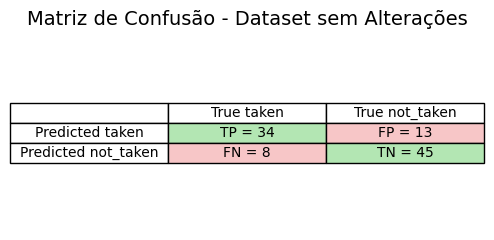


DATASET COM NOISE
Previsões: ['not_taken', 'not_taken', 'not_taken', 'taken', 'taken', 'not_taken', 'not_taken', 'taken', 'taken', 'not_taken', 'not_taken', 'taken', 'not_taken', 'not_taken', 'not_taken', 'taken', 'not_taken', 'not_taken', 'taken', 'taken', 'not_taken', 'taken', 'taken', 'not_taken', 'not_taken', 'taken', 'taken', 'not_taken', 'not_taken', 'not_taken', 'not_taken', 'not_taken', 'taken', 'taken', 'not_taken', 'not_taken', 'taken', 'taken', 'taken', 'not_taken', 'not_taken', 'not_taken', 'taken', 'not_taken', 'not_taken', 'not_taken', 'not_taken', 'taken', 'not_taken', 'not_taken', 'taken', 'not_taken', 'taken', 'not_taken', 'taken', 'not_taken', 'taken', 'taken', 'taken', 'taken', 'not_taken', 'not_taken', 'not_taken', 'taken', 'taken', 'not_taken', 'not_taken', 'taken', 'not_taken', 'not_taken', 'not_taken', 'not_taken', 'not_taken', 'not_taken', 'taken', 'taken', 'taken', 'not_taken', 'not_taken', 'taken', 'taken', 'taken', 'taken', 'taken', 'not_taken', 'taken', 'ta

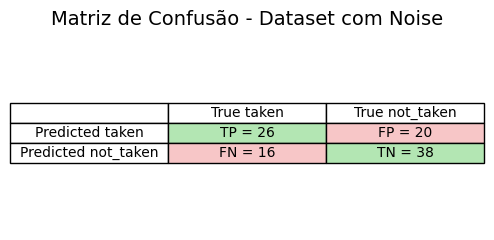


DATASET COM OUTLIERS
Previsões: ['taken', 'not_taken', 'not_taken', 'not_taken', 'taken', 'taken', 'not_taken', 'taken', 'not_taken', 'not_taken', 'not_taken', 'not_taken', 'not_taken', 'not_taken', 'not_taken', 'taken', 'taken', 'not_taken', 'not_taken', 'not_taken', 'not_taken', 'taken', 'taken', 'not_taken', 'not_taken', 'not_taken', 'taken', 'not_taken', 'not_taken', 'taken', 'not_taken', 'taken', 'not_taken', 'taken', 'taken', 'not_taken', 'not_taken', 'taken', 'not_taken', 'not_taken', 'taken', 'not_taken', 'taken', 'not_taken', 'taken', 'taken', 'not_taken', 'not_taken', 'taken', 'taken', 'not_taken', 'taken', 'not_taken', 'not_taken', 'taken', 'not_taken', 'taken', 'taken', 'taken', 'not_taken', 'not_taken', 'not_taken', 'not_taken', 'taken', 'taken', 'not_taken', 'not_taken', 'not_taken', 'taken', 'not_taken', 'not_taken', 'not_taken', 'not_taken', 'taken', 'not_taken', 'taken', 'taken', 'taken', 'taken', 'taken', 'not_taken', 'not_taken', 'taken', 'not_taken', 'taken', 'take

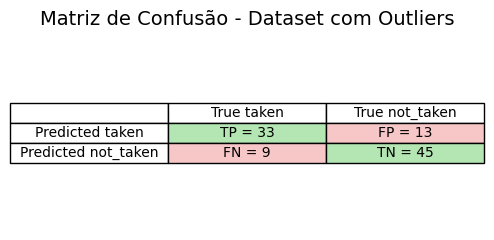

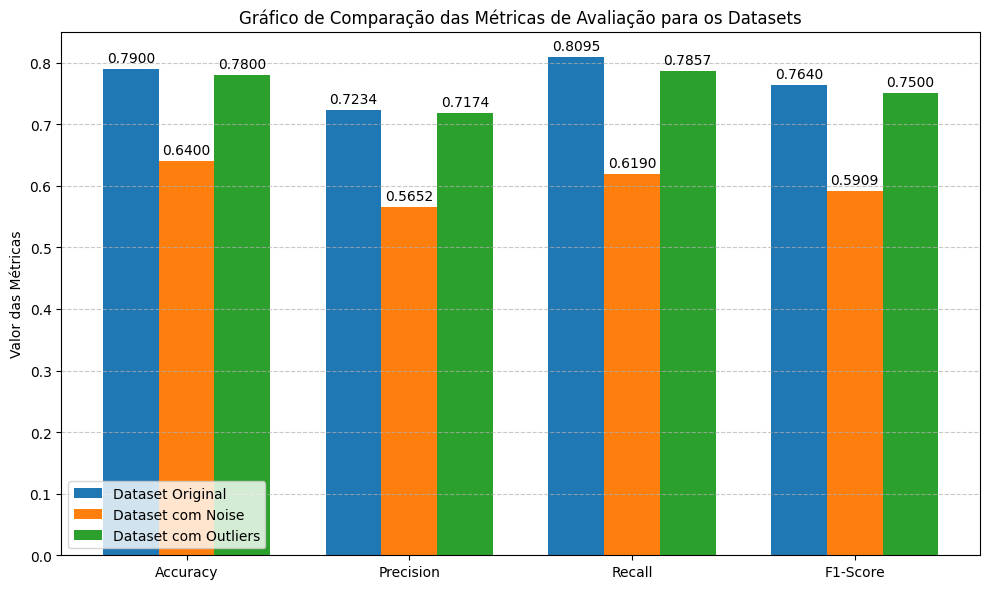

In [8]:
dataset = input("Insira o path do dataset: ")
nivel_noise = float(input("Insira o nível de noise (entre 0 e 1): "))
nivel_outliers = float(input("Insira o nível de outliers (entre 0 e 1): "))

df = pd.read_csv(dataset)

y = df.iloc[:, -1].values   # y contem os valores da última coluna = classe
X = pd.get_dummies(df.iloc[:, :-1]).values.astype(float)    # X fica com todas as colunas menos a última, usa get_dummies() para fazer One-Hot Encoding

X = celulas_vazias(X)

indices = np.arange(len(X))
np.random.seed(42)  # faz com que o embaralhamento seja sempre o mesmo quando se corre o código
np.random.shuffle(indices)  # embaralha a ordem dos indices
# reorganiza os dados
X = X[indices]
y = y[indices]

# dividir o dataset em 80% treino e 20% teste
split_idx = int(0.8 * len(X))
X_train = X[:split_idx]
y_train = y[:split_idx]
X_test = X[split_idx:]
y_test = y[split_idx:]

#-----------------------------------------------------
# Dataset sem alterações
modelo = KNN(k=5)
modelo.fit(X_train, y_train)
prediction = modelo.predict(X_test)
accuracy, precision, recall, f1_score = metricas(y_test, prediction)

# Datset com noise
y_noise = noise(y_train, nivel_noise)
modelo_noise = KNN(k=5)
modelo_noise.fit(X_train, y_noise)
prediction_noise = modelo_noise.predict(X_test)
accuracy_noise, precision_noise, recall_noise, f1_noise = metricas(y_test, prediction_noise)

# Dataset com outliers
X_outliers, y_outliers = outliers(X_train, y_train, nivel_outliers, magnitude=10)
modelo_outliers = KNN(k=5)
modelo_outliers.fit(X_outliers, y_outliers)
prediction_outliers = modelo_outliers.predict(X_test)
accuracy_outliers, precision_outliers, recall_outliers, f1_outliers = metricas(y_test, prediction_outliers)

#-----------------------------------------------------------------------------------
# Dataset sem alterações
print("\nDATASET SEM ALTERAÇÕES")
print("Previsões:", [str(p) for p in prediction])
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_score:.4f}")
fig, ax = plt.subplots(figsize=(5, 2.5))
matriz_confusao(y_test, prediction, ax, title="Matriz de Confusão - Dataset sem Alterações")
plt.tight_layout()
plt.show()

# Dataset com adição de Noise
print("\nDATASET COM NOISE")
print("Previsões:", [str(p) for p in prediction_noise])
print(f"Accuracy com {int(nivel_noise * 100)}% de ruído: {accuracy_noise:.4f}")
print(f"Precision: {precision_noise:.4f}")
print(f"Recall: {recall_noise:.4f}")
print(f"F1-score: {f1_noise:.4f}")
fig, ax = plt.subplots(figsize=(5, 2.5))
matriz_confusao(y_test, prediction_noise, ax, title="Matriz de Confusão - Dataset com Noise")
plt.tight_layout()
plt.show()

# Dataset com adição de Outliers
print("\nDATASET COM OUTLIERS")
print("Previsões:", [str(p) for p in prediction_outliers])
print(f"Accuracy com {int(nivel_outliers * 100)}% de outliers: {accuracy_outliers:.4f}")
print(f"Precision: {precision_outliers:.4f}")
print(f"Recall: {recall_outliers:.4f}")
print(f"F1-score: {f1_outliers:.4f}")
fig, ax = plt.subplots(figsize=(5, 2.5))
matriz_confusao(y_test, prediction_outliers, ax, title="Matriz de Confusão - Dataset com Outliers")
plt.tight_layout()
plt.show()

# Gráfico de Comparação
metricas_original = [accuracy, precision, recall, f1_score]
metricas_noise = [accuracy_noise, precision_noise, recall_noise, f1_noise]
metricas_outliers = [accuracy_outliers, precision_outliers, recall_outliers, f1_outliers]
grafico_metricas(metricas_original, metricas_noise, metricas_outliers)

## Conclusões

- O K-NN revelou-se relativamente sensível à introdução de noise. Observou-se, em alguns casos, uma descida no valor das métricas de desempenho como accuracy, precision, recall e f1-score. No entanto, em alguns datasets, uma pequena quantidade de noise contribuiu para uma pequena melhoria no desempenho, possivelmente porque o noise ajudou a quebrar padrões artificiais ou enviesados presentes nos dados originais.
  
- A presença de outliers nas características (X_train) afetou negativamente o desempenho do KNN de forma mais consistente. Mas em certos casos verificámos que houve uma pequena melhoria das métricas de avaliação. Isto pode ser explicado pelo facto de alguns outliers, gerados aleatoriamente, terem aumentado a separação entre as classes presentes no dataset original.

- No geral apesar das perturbações introduzidas, o K-NN manteve, em muitos casos, uma boa capacidade de classificação, especialmente quando os níveis de noise e outliers foram pequenos. No entanto, como esperado, níveis muito elevados de perturbação resultaram numa queda significativa do desempenho.

In [9]:
!pip install matplotlib
